# Simple MNIST Neural Network from scratch

*This is a simple NN made to identify handwritten numbers from the MNIST dataset. This code uses no external NN libararies like TensorFlow or PyTorch but instead uses just Numpy, Linear Algebra and a little sprinkle of Calculus*

In [2]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
from matplotlib import pyplot as plt # type: ignore

In [7]:
# Load training data
data_train = pd.read_csv('train.csv')
data_train = np.array(data_train)
m_train, n_train = data_train.shape
np.random.shuffle(data_train)  # shuffle the training data

# Prepare training set
data_train = data_train.T
Y_train = data_train[0]
X_train = data_train[1:n_train]
X_train = X_train / 255.0  # normalize

# Load test data (as dev set)
data_dev = pd.read_csv('test.csv')
data_dev = np.array(data_dev)
m_dev, n_dev = data_dev.shape

# Prepare dev set
data_dev = data_dev.T
Y_dev = data_dev[0]
X_dev = data_dev[1:n_dev]
X_dev = X_dev / 255.0  # normalize


In [28]:
Y_train

array([0, 8, 5, ..., 3, 0, 7], dtype=int64)

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [29]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, m_train):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m_train * dZ2.dot(A1.T)
    db2 = 1 / m_train * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m_train * dZ1.dot(X.T)
    db1 = 1 / m_train * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

To track overfitting, we need to monitor both training and validation losses, as well as training and validation accuracy over the course of the training. To achieve this, we need to add a function to compute the loss (cross-entropy loss for classification problems like MNIST). 

The formula for cross-entropy loss is:

$$\text{Loss} = -\frac{1}{m} \sum (Y \cdot \log(\hat{Y}))$$

where $Y$ is the one-hot encoded true label, $\hat{Y}$ is the predicted probability from the softmax function, and $m$ is the size of the dataset.



In [30]:
def compute_loss(A2, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    return -np.sum(one_hot_Y * np.log(A2)) / m

In [31]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    # print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X_train, Y_train, X_dev, Y_dev, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    m_train = X_train.shape[1]  # number of training samples

    for i in range(iterations + 1):
        # Forward prop on training set
        Z1_train, A1_train, Z2_train, A2_train = forward_prop(W1, b1, W2, b2, X_train)
        
        # Backprop and update parameters
        dW1, db1, dW2, db2 = backward_prop(Z1_train, A1_train, Z2_train, A2_train, W1, W2, X_train, Y_train, m_train)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Calculate training loss and accuracy
        train_loss = compute_loss(A2_train, Y_train)
        train_accuracy = get_accuracy(get_predictions(A2_train), Y_train)
        
        # Forward prop on validation set
        Z1_dev, A1_dev, Z2_dev, A2_dev = forward_prop(W1, b1, W2, b2, X_dev)
        val_loss = compute_loss(A2_dev, Y_dev)
        val_accuracy = get_accuracy(get_predictions(A2_dev), Y_dev)
        
        # Store losses and accuracies for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print progress every 10 iterations
        if i % 10 == 0:
            print(f"Iteration: {i}")
            print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return W1, b1, W2, b2, train_losses, val_losses, train_accuracies, val_accuracies

In [32]:
W1, b1, W2, b2, train_losses, val_losses, train_accuracies, val_accuracies = gradient_descent(X_train, Y_train, X_dev, Y_dev, 0.1, 5000)

# If the training loss is decreasing but the validation loss is increasing, this is a key sign of overfitting
# Stop training if this occurs

Iteration: 0
Training Loss: 3.2785, Training Accuracy: 0.1021
Validation Loss: 2.9957, Validation Accuracy: 0.1003
Iteration: 10
Training Loss: 2.3063, Training Accuracy: 0.1645
Validation Loss: 2.2595, Validation Accuracy: 0.1717
Iteration: 20
Training Loss: 2.0672, Training Accuracy: 0.2637
Validation Loss: 2.0277, Validation Accuracy: 0.2714
Iteration: 30
Training Loss: 1.8930, Training Accuracy: 0.3453
Validation Loss: 1.8514, Validation Accuracy: 0.3598
Iteration: 40
Training Loss: 1.7398, Training Accuracy: 0.4042
Validation Loss: 1.6952, Validation Accuracy: 0.4234
Iteration: 50
Training Loss: 1.6007, Training Accuracy: 0.4531
Validation Loss: 1.5536, Validation Accuracy: 0.4747
Iteration: 60
Training Loss: 1.4758, Training Accuracy: 0.4961
Validation Loss: 1.4269, Validation Accuracy: 0.5179
Iteration: 70
Training Loss: 1.3648, Training Accuracy: 0.5335
Validation Loss: 1.3150, Validation Accuracy: 0.5513
Iteration: 80
Training Loss: 1.2674, Training Accuracy: 0.5666
Validation

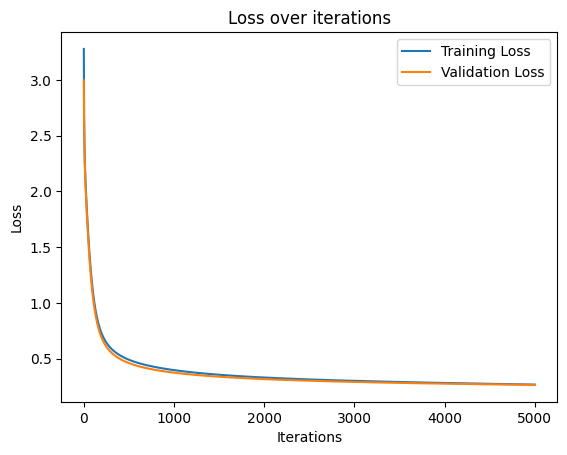

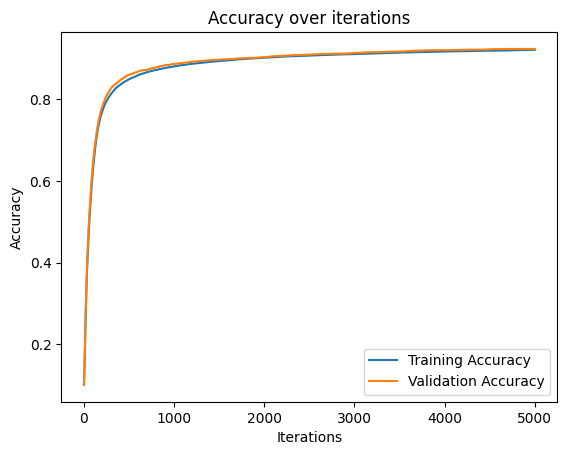

In [33]:
# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show(block=False)

# Create the second plot for training and validation accuracy
plt.figure()
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2, total_tests):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    
    current_image = current_image.reshape((28, 28)) * 255
    
    plt.figure()
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    
    plt.title(f"Predicted: {prediction[0]}, Actual: {label}")
    
    if index == total_tests - 1:
        plt.show()
    else:
        plt.show(block=False)

Let's look at a couple of examples:

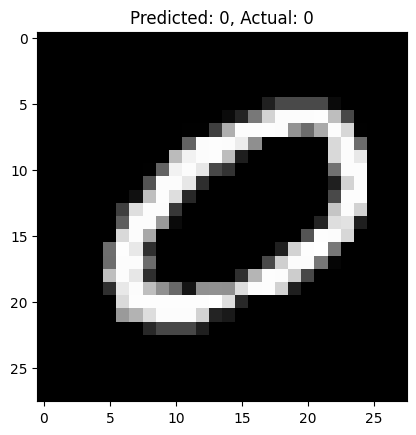

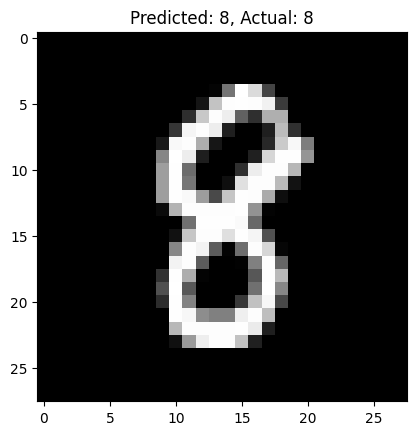

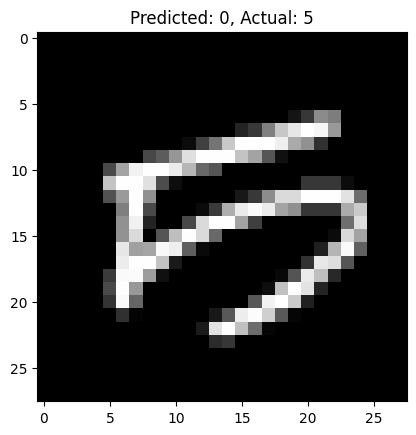

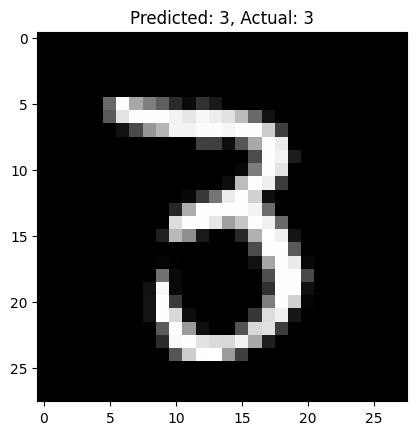

In [35]:
total_tests = 4

for i in range(total_tests):
    test_prediction(i, W1, b1, W2, b2, total_tests)

Finally, let's find the accuracy on the dev set:

In [37]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
print(dev_predictions, Y_dev)
print(f"Validation Accuracy: {get_accuracy(dev_predictions, Y_dev):.4f}")

[2 1 0 ... 4 5 6] [2 1 0 ... 4 5 6]
Validation Accuracy: 0.9238
